# Setup

In [1]:
import setup
import os

# Dataset Downloading

Covid-19 Image Classification

In [2]:
#!curl -L -o /content/sample_data/covid19-image-dataset.zip\
#  https://www.kaggle.com/api/v1/datasets/download/pranavraikokte/covid19-image-dataset

In [3]:
#from zipfile import ZipFile
#with ZipFile('/content/sample_data/covid19-image-dataset.zip') as zp:
#  zp.extractall('/content/sample_data/')

# Data Loading

In [4]:
# Checking Biggest Image Sizes
from glob import glob
from setup import DATA_PATH
import os
from PIL import Image
imgs = glob(os.path.join(DATA_PATH, 'train', '*', '*.jpg'), recursive=True) + glob(os.path.join(DATA_PATH, 'train', '*', '*.png'), recursive=True) + glob(os.path.join(DATA_PATH, 'train', '*', '*.jpeg'), recursive=True)

widths = []
heights = []

#print(imgs)

for img in imgs:
    pil_image = Image.open(img)
    print(img, pil_image.width, pil_image.height)
    widths.append(pil_image.width)
    heights.append(pil_image.height)

print(f'Largest: width {max(widths)} and height {max(heights)}')
print(f'Mean values: width {sum(widths)/len(widths)} and height {sum(heights)/len(heights)}')

/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00004.jpg 1050 973
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00025.jpg 895 734
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00029.jpg 785 664
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00018.jpg 1213 1611
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00002.jpg 2665 2197
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/073.jpg 1534 1517
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00011.jpg 1743 1674
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00003a.jpg 1502 1192
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/COVID-00024.jpg 849 695
/home/guilherme/code/python/Covid19_CNN/dataset/Covid19-dataset/train/Covid/089.jpg 999 816
/hom

In [5]:
from torchvision import datasets, transforms
from setup import IMAGE_WIDTH, IMAGE_HEIGHT
from data.loading import load_data
from math import ceil

transform = transforms.Compose([transforms.Resize(size=(IMAGE_WIDTH, IMAGE_HEIGHT)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
train_ds, test_ds = load_data(transform)

NUM_IMGS = len(train_ds.imgs)
NUM_BATCHES = ceil(NUM_IMGS/setup.BATCH_SIZE)


We might not have to create a custom dataset, because we can use ImageFolder to create a dataset from an image folder with an organized structure. It will automatically associate the class names to images according to folder names.

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
from setup import BATCH_SIZE


loader = DataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

iterable_ds = iter(loader)


Images loaded are of different sizes, which would cause a
```
RuntimeError: stack expects each tensor to be equal size, but got [3, 3480, 4248] at entry 0 and [3, 1303, 1458] at entry 1

```

We can fix that by assuring all images are of the same size. Use a transform for that.

https://discuss.pytorch.org/t/runtimeerror-stack-expects-each-tensor-to-be-equal-size-but-got-3-224-224-at-entry-0-and-3-224-336-at-entry-3/87211

Apparently, we can normalize the channels to make sure brighter colors won't be of more importance. Use a transform for that.

https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

# Analyzing Data

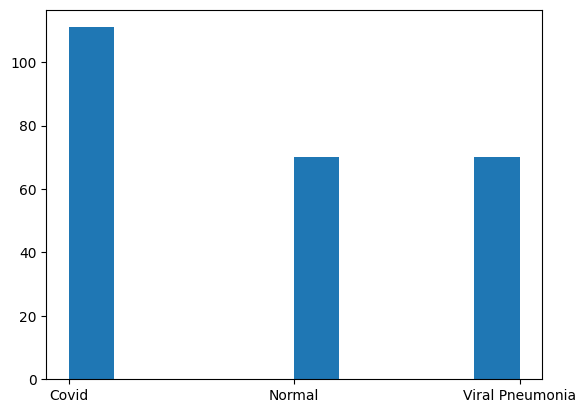

,Img_Uri
Class,
0,111
1,70
2,70


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(train_ds.imgs)
df = df.rename(columns={0: 'Img_Uri', 1: 'Class'})
classes = df.loc[:, 'Class']

plt.hist(classes)
plt.xticks([0, 1, 2], labels=train_ds.classes)
plt.show()

df.groupby(['Class']).count()

In [8]:
df

,Img_Uri,Class
0,/home/guilherme/code/python/Covid19_CNN/datase...,0
1,/home/guilherme/code/python/Covid19_CNN/datase...,0
2,/home/guilherme/code/python/Covid19_CNN/datase...,0
3,/home/guilherme/code/python/Covid19_CNN/datase...,0
4,/home/guilherme/code/python/Covid19_CNN/datase...,0
...,...,...
246,/home/guilherme/code/python/Covid19_CNN/datase...,2
247,/home/guilherme/code/python/Covid19_CNN/datase...,2
248,/home/guilherme/code/python/Covid19_CNN/datase...,2
249,/home/guilherme/code/python/Covid19_CNN/datase...,2


# Modifying Data

-> Undersampling

In [9]:
i = 0
new_imgs = []
for img in train_ds.imgs:
  if img[1] == 0:
    if i >= 70:
      continue
    i += 1

  new_imgs.append(img)

#train_ds.imgs = new_imgs

#print(len(train_ds.imgs))
#print(len(list(filter(lambda x: x[1] == 0, train_ds.imgs))))

# Declaring Components

- Model
- Optimizer
- Loss Function
- Scheduler

## Making Model

In [10]:
from torch import nn, softmax, relu
from model.CNN_Model import CNN_Model
from setup import IMAGE_HEIGHT, IMAGE_WIDTH, FINE_TUNE
from torchvision.models import resnet18

model = None

if FINE_TUNE:
    print(f'Using fine tuning strategy.')
    # Based on: https://youtu.be/c36lUUr864M?si=nLzRzN_VFT8HSmiu
    model = resnet18(pretrained=True)
    for params in model.parameters():
        params.requires_grad = False
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3) # adjusting last layer to fit our 3 classes
else:
    print(f'Using custom model.')
    model = CNN_Model(image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

Using fine tuning strategy.


/home/guilherme/code/python/Covid19_CNN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guilherme/code/python/Covid19_CNN/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Setting Up Optimizer, Loss Function and Scheduler

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=setup.LEARNING_RATE, momentum=0.9)
loss = nn.CrossEntropyLoss()

# Setting Up Scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(
    optimizer,
    step_size=4,
    gamma=0.1
)

# Training

Apparently, to run on the GPU, we have to send the data itself to the GPU. We can do so with the batches. The loss function also needs the labels to be loaded on the GPU.

https://discuss.pytorch.org/t/how-to-load-all-data-into-gpu-for-training/27609/22?page=2

Also, we need the weights to be on the GPU. We can do that by using the model itself, sending it to the GPU as well.

https://discuss.pytorch.org/t/how-to-load-all-data-into-gpu-for-training/27609/34?page=2

In [12]:
# GPU or CPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device=device)

Tqdm is a simple library that can be used to generate a loading bar on loops.

https://github.com/tqdm/tqdm

In [13]:
from model.train import train

train(
    model=model,
    num_batches=NUM_BATCHES,
    num_epochs=setup.NUM_EPOCHS,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
    dataset=train_ds,
    loss=loss,
    num_imgs=NUM_IMGS
)

Epoch 0: 100%|██████████| 26/26 [00:14<00:00,  1.85it/s]

Epoch 0 | Accuracy: 65.3386%
Switching to model with accuracy of 65.3386%


# Evaluation

Evaluating with Test Data

In [16]:
from data.evaluation import evaluate_model

model = model.eval()

evaluate_model(model=model,
               test_data=test_ds,
               batch_size=BATCH_SIZE
               )

100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Accuracy: 31/66 | 46.9697%
[[14  5  7]
 [ 3 12  5]
 [ 8  7  5]]


In [15]:
from data.evaluation import evaluate_model

model = model.eval()

evaluate_model(model=model,
               test_data=test_ds,
               batch_size=1
               )


  6%|▌         | 4/66 [00:02<00:37,  1.63it/s]


KeyboardInterrupt: 

In [ ]:
from data.evaluation import evaluate_model, evaluate_single

#evaluate_model(model=model,
#               test_data=test_ds,
#               batch_size=1
#               )

evaluate_single(model=model, classes_list=['Covid', 'Normal', 'Viral Pneumonia'])

-------------------- Running Images of Class  Covid
-------------------- Running Images of Class  Normal
-------------------- Running Images of Class  Viral Pneumonia

Accuracy: 27/66 | 40.9091%


# Saving Model

In [ ]:
from model.save_model import save_model

save_model(model=model, optimizer=optimizer)

Saved file model_25_27_08_18_31.pth at /home/guilherme/code/python/Covid19_CNN/src/model/saved
